In [ ]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn # nn stands for neural network and this package contains the building blocks for creating neural networks in PyTorch
import matplotlib.pyplot as plt


In [ ]:
torch.__version__

'2.5.1+cu121'

### 1.Data (preparing and loading)
here we create  the data first and use it for training the model and use linear regression model with known parameters

In [ ]:
# create parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y =  weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# split the data for training and test
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

In [ ]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [ ]:
def plot_pred(train_data = X_train,
              train_label = y_train,
              test_data = X_test,
              test_label = y_test,
              predictions = None):

  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_label,c="b",s=4,label="training data")
  plt.scatter(test_data,test_label,c='g',s=4,label="testing data")
  if predictions is not None:
    plt.scatter(test_data,predictions,c="r",s=4,label="predictions")
  plt.legend(prop={"size":14})

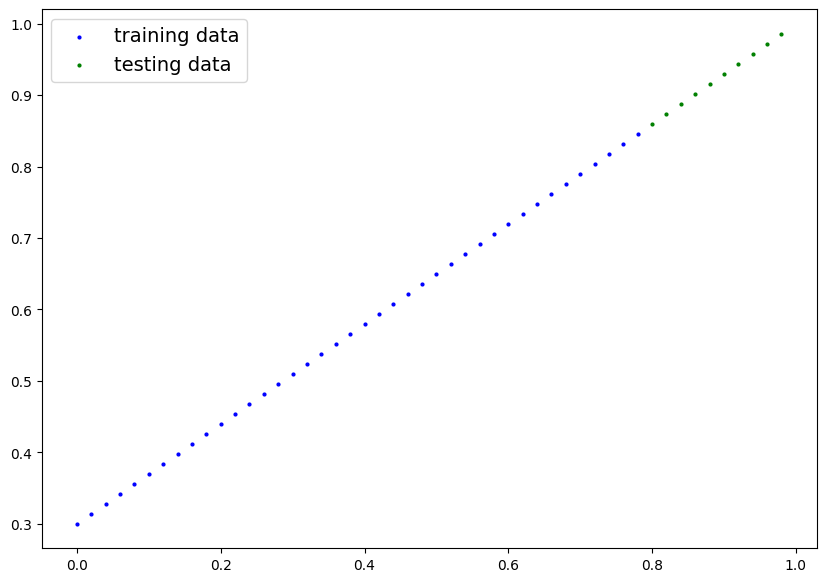

In [ ]:
plot_pred()

In [ ]:
# Build modell first pytorch model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight  = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                             dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                           dtype=torch.float))

  def forward(self,x:torch.Tensor) -> torch.Tensor:
      return self.weight * x + self.bias




### PyTorch model building essentials
* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [ ]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using torch.inference_mode()
To check our model's predictive power, let's see how well it predicts y_test based on X_test.

When we pass data through our model, it's going to run it through the forward() method

In [ ]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [ ]:
# making prediction

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

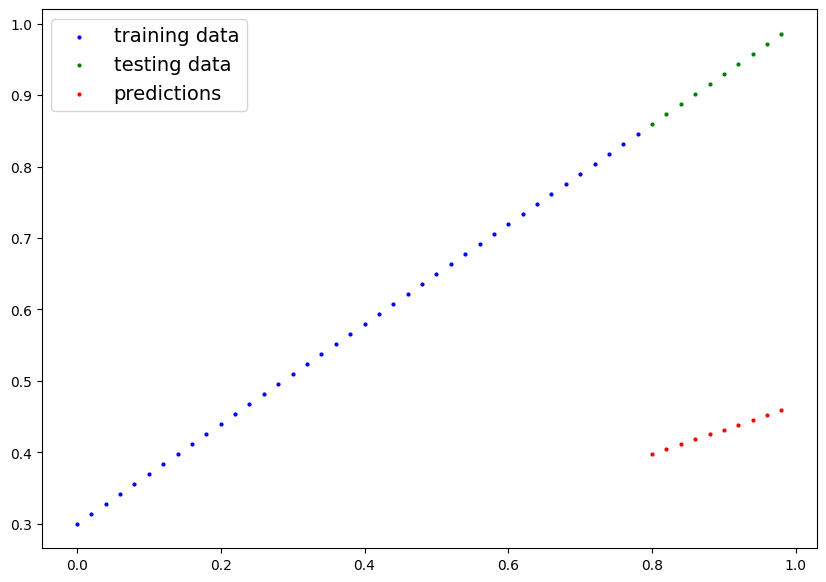

In [ ]:
plot_pred(predictions=y_preds)


### 3.Train the model
* Loss function: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* Optimizer: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://pytorch.org/docs/stable/optim.html#module-torch.optim
Inside the optimizer you'll often have to set two parameters:
params - the model parameters you'd like to optimize, for example params=model_0.parameters()
lr (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small lr results in small changes, a large lr results in large changes)
And specifically for PyTorch, we need:

* A training loop
* A testing loop

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()


In [ ]:
optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters present in our model
                            lr=0.01)

In [ ]:
# Buildin a training loop
torch.manual_seed(42)
epochs = 200


epoch_count = []
loss_values = []
test_loss_values = []
for epoch in range(epochs):
  model_0.train()

  #1,Forward pass
  y_pred = model_0(X_train)

   # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. BackPropogation
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():

    # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

     # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())





Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:

with torch.inference_mode():
  y_pred_new = model_0(X_test)

In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

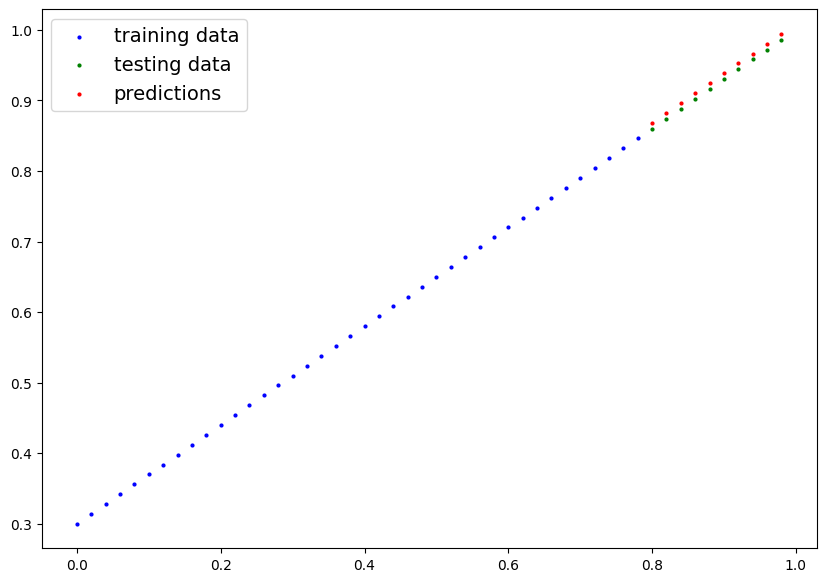

In [ ]:
plot_pred(predictions=y_pred_new)

In [ ]:
import numpy as np
np.array(torch.tensor(loss_values).numpy()), test_loss_values

(array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
        0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
        0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
        0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.4811),
  tensor(0.3464),
  tensor(0.2173),
  tensor(0.1446),
  tensor(0.1136),
  tensor(0.0992),
  tensor(0.0889),
  tensor(0.0806),
  tensor(0.0723),
  tensor(0.0647),
  tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

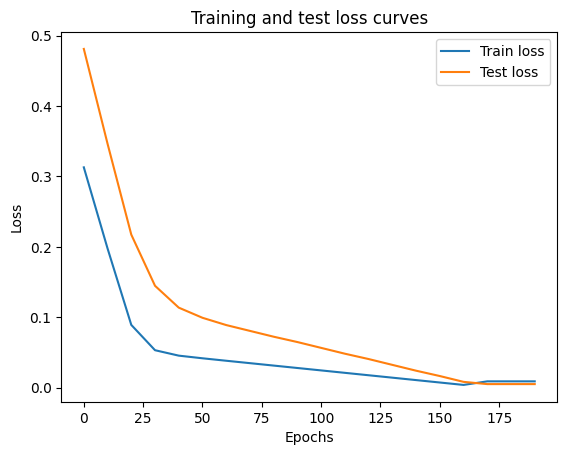

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
model_0.state_dict()

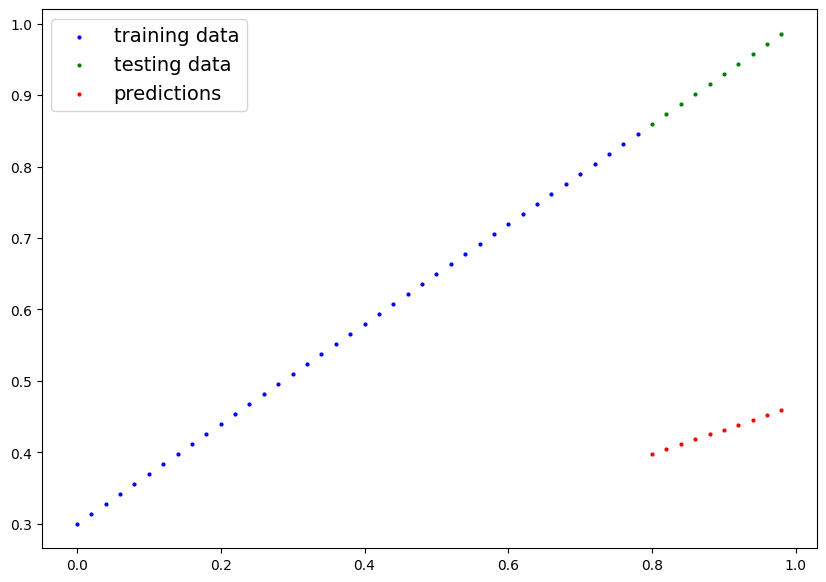

In [ ]:
plot_pred(predictions=y_preds);


### SAving a pytorh model

In [ ]:
# Saving a model in pytorch
from pathlib import Path

Model_path = Path('models')
Model_path.mkdir(parents=True,exist_ok = True)

Model_name = '01_pytorch_workflow.pth'
save_path = Model_path / Model_name

print(f"Saving model to: {save_path}")
torch.save(obj=model_0.state_dict(),
           f=save_path)

Saving model to: models/01_pytorch_workflow.pth


In [ ]:
! ls -l models

total 4
-rw-r--r-- 1 root root 1568 Jan 26 10:57 01_pytorch_workflow.pth


In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

### Loading a pytorch model

In [ ]:
loaded_model_0 = LinearRegressionModel()

In [ ]:
loaded_model_0.load_state_dict(torch .load(f=save_path))

<ipython-input-86-d35a6cf7f47d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch .load(f=save_path))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
y_preds = loaded_model_preds